In [11]:
import os
import sys
sys.path.append('../src')
import numpy as np

from generator import generate_samples
from utils import split_and_preprocess
from adjustment_methods import (
    get_ate_ols,
    get_ate_cuped,
    get_ate_cupac,
    get_ate_doubly_robust,
)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using the generator to generate some samples

### With no covariates

In [12]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=1,
    size=10_000,
    cov_mu_eps=[],
    non_linear=[],
    p_binomial=0.1,
    seed=0,
)
data

,Y,T,Y_before,R_1
0,6.527356,0,5.460076,-0.187331
1,5.214514,1,3.790229,-0.568764
2,4.966742,0,3.648757,0.412930
3,5.794092,0,3.633204,-1.485097
4,5.285567,0,5.014823,1.642086
...,...,...,...,...
9995,4.710937,0,5.364423,-2.743185
9996,12.048095,0,5.112235,0.360046
9997,4.082669,0,5.142005,0.613257
9998,7.930163,0,5.232795,-0.009023


### With covariates

In [13]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=2,
    size=10_000,
    cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    non_linear=[False, False, True],
    p_binomial=0.5,
    seed=0,
)
data

,Y,T,Y_before,X_1,X_2,X_3,R_1
0,10.652106,0,4.266313,0.191957,-1.763622,2.776427,0.723661
1,28.291109,1,4.012173,-0.419272,-1.498237,4.870046,0.128917
2,38.195960,0,4.890613,-1.151834,-4.205427,6.279805,-0.174498
3,20.459232,1,5.382098,-3.264159,-4.321669,4.568285,-0.609975
4,33.735483,0,5.006805,-1.020055,-1.779481,5.384873,-0.667309
...,...,...,...,...,...,...,...
9995,21.268036,1,2.767599,-1.138728,-1.956217,4.503508,-0.194357
9996,14.566230,1,3.630337,-1.379941,-1.200647,3.597359,-1.496386
9997,16.306194,1,3.233966,-2.236512,-1.909526,3.708555,-0.325130
9998,22.282606,0,6.734815,-0.049832,-2.781651,4.467106,-0.138784


# Getting a single ATE for this data

In [14]:
train_data, test_data = split_and_preprocess(data, treatment_effect=2)
len(train_data), len(test_data)

(5000, 5000)

# Mean Diff

In [15]:
test_data.loc[test_data['T']==1, 'Y'].mean() - test_data.loc[test_data['T']==0, 'Y'].mean()

2.0564593282397396

### CUPED

Only uses outcome pre experiment

In [16]:
get_ate_cuped(test_data)

2.0384995741562513

### Multivariable regression

In [17]:
get_ate_ols(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

2.054476609053416

### CUPAC

In [18]:
get_ate_cupac(test_data, train_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.9479159970566222

### Doubly Robust

In [19]:
get_ate_doubly_robust(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

2.039234184376177

## Simulating the experiment many times, supposing only linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3 + \epsilon$$

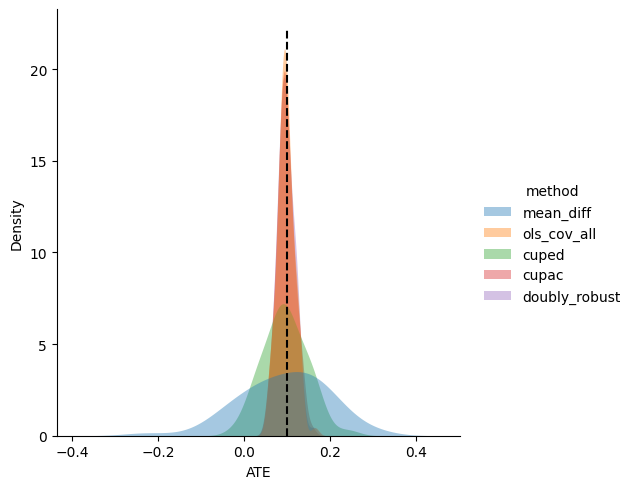

,method,mse
0,cupac,0.000392
1,cuped,0.002638
2,doubly_robust,0.000375
3,mean_diff,0.010566
4,ols_cov_all,0.000362


In [20]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

## Now simulating the same linear process, but using only a random variable as a covariate

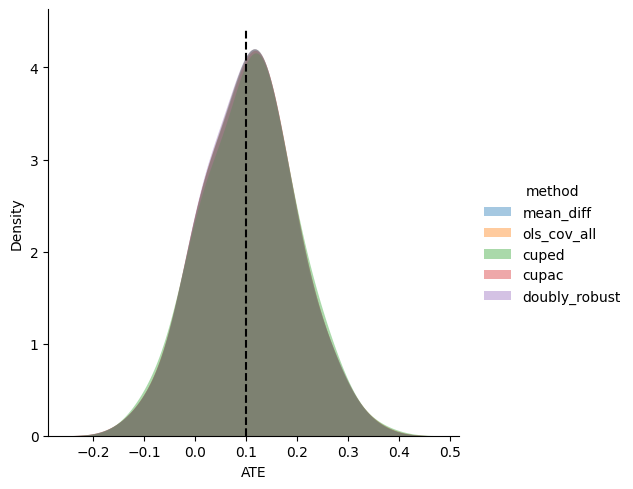

,method,mse
0,cupac,0.007752
1,cuped,0.008032
2,doubly_robust,0.007681
3,mean_diff,0.007700
4,ols_cov_all,0.007705


In [21]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['R_1']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['R_1']))
    ate_cuped.append(get_ate_cuped(analysis_data, prediction_column='R_1'))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['R_1']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

## Simulating now with non-linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3^2 + \epsilon$$

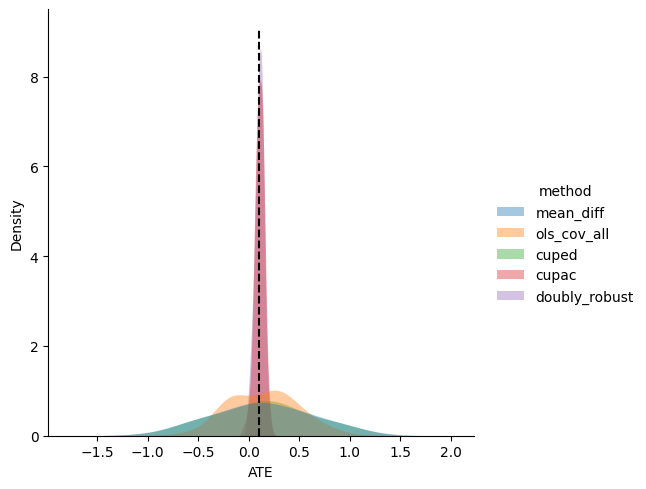

,method,mse
0,cupac,0.002084
1,cuped,0.224097
2,doubly_robust,0.001827
3,mean_diff,0.235074
4,ols_cov_all,0.109270


In [22]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
        non_linear=[False, False, True]
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()